In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(context='notebook', style='darkgrid') 

In [2]:
df=pd.read_csv("../input/taylorswiftlyricsfeatures/TaylorSwiftLyricsFeatureSet.csv")
df=df.rename(columns={"Album":"track_album","Artist":"track_artist","Track":"track_title","TrackURI":"track_uri" , "TrackID":"track_id" ,"Lyrics":"track_lyric"})

In [3]:
data = df.drop(columns=["track_lyric"],axis=0)
data.head()

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_uri,track_id,genres
0,Taylor Swift,Taylor Swift,Tim McGraw,0.580,0.491,0,-6.462,1,0.0251,0.575,0.0,0.1210,0.425,76.009,232107,4,spotify:track:0Om9WAB5RS09L80DyOfTNa,0Om9WAB5RS09L80DyOfTNa,Country
1,Taylor Swift,Taylor Swift,Picture To Burn,0.658,0.877,7,-2.098,1,0.0323,0.173,0.0,0.0962,0.821,105.586,173067,4,spotify:track:32mVHdy0bi1XKgr0ajsBlG,32mVHdy0bi1XKgr0ajsBlG,Country Rock
2,Taylor Swift,Taylor Swift,Teardrops On My Guitar,0.621,0.417,10,-6.941,1,0.0231,0.288,0.0,0.1190,0.289,99.953,203040,4,spotify:track:7zMcNqs55Mxer82bvZFkpg,7zMcNqs55Mxer82bvZFkpg,Country Pop
3,Taylor Swift,Taylor Swift,A Place In This World,0.576,0.777,9,-2.881,1,0.0324,0.051,0.0,0.3200,0.428,115.028,199200,4,spotify:track:73OX8GdpOeGzKC6OvGSbsv,73OX8GdpOeGzKC6OvGSbsv,Country Pop
4,Taylor Swift,Taylor Swift,Cold as You,0.418,0.482,5,-5.769,1,0.0266,0.217,0.0,0.1230,0.261,175.558,239013,4,spotify:track:7an1exwMnfYRcdVQm0yDev,7an1exwMnfYRcdVQm0yDev,Country


## Exploratory Data Analysis

In [4]:
XtoPredict = data.loc[data['genres'].isnull(),:].drop(columns=['track_uri','track_id']).reset_index(drop=True)
FeatureSet = data.loc[data['genres'].notnull(),:].drop(columns=['track_uri','track_id']).reset_index(drop=True)
FeatureSet.head()

,track_album,track_artist,track_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
0,Taylor Swift,Taylor Swift,Tim McGraw,0.580,0.491,0,-6.462,1,0.0251,0.575,0.0,0.1210,0.425,76.009,232107,4,Country
1,Taylor Swift,Taylor Swift,Picture To Burn,0.658,0.877,7,-2.098,1,0.0323,0.173,0.0,0.0962,0.821,105.586,173067,4,Country Rock
2,Taylor Swift,Taylor Swift,Teardrops On My Guitar,0.621,0.417,10,-6.941,1,0.0231,0.288,0.0,0.1190,0.289,99.953,203040,4,Country Pop
3,Taylor Swift,Taylor Swift,A Place In This World,0.576,0.777,9,-2.881,1,0.0324,0.051,0.0,0.3200,0.428,115.028,199200,4,Country Pop
4,Taylor Swift,Taylor Swift,Cold as You,0.418,0.482,5,-5.769,1,0.0266,0.217,0.0,0.1230,0.261,175.558,239013,4,Country


FeatureSet will be the one that is used to train and test out our Model.

In [5]:
print(len(FeatureSet.genres.unique()))

country = ['Country Pop','Country','Folk Pop','Blue grass','Contemporary Country']
pop = ['Pop','Electropop','Synth Pop','Dance Pop','Dream Pop']
rock = ['Pop Rock','Pop Punk','Alternative Rock','Soft Rock','R&B','Country Rock',]

print(len(rock)+len(country)+len(pop))

16
16


In [6]:
genre_broad = []
for index,i in enumerate(FeatureSet.genres):
    if i in country:
        genre_broad.append('country')
    
    if i in rock:
        genre_broad.append('rock')
    
    if i in pop:
        genre_broad.append('pop')
        
FeatureSet['genre_broad']=genre_broad

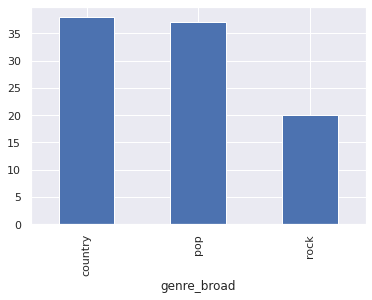

In [7]:
FeatureSet.groupby('genre_broad').count()['track_title'].plot.bar()

Text(0.5, 1.0, 'Duration (to check outliers)')

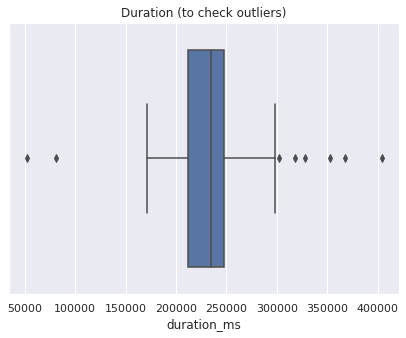

In [8]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='duration_ms',data=FeatureSet)
plt.title("Duration (to check outliers)")

### Correlation between the different features

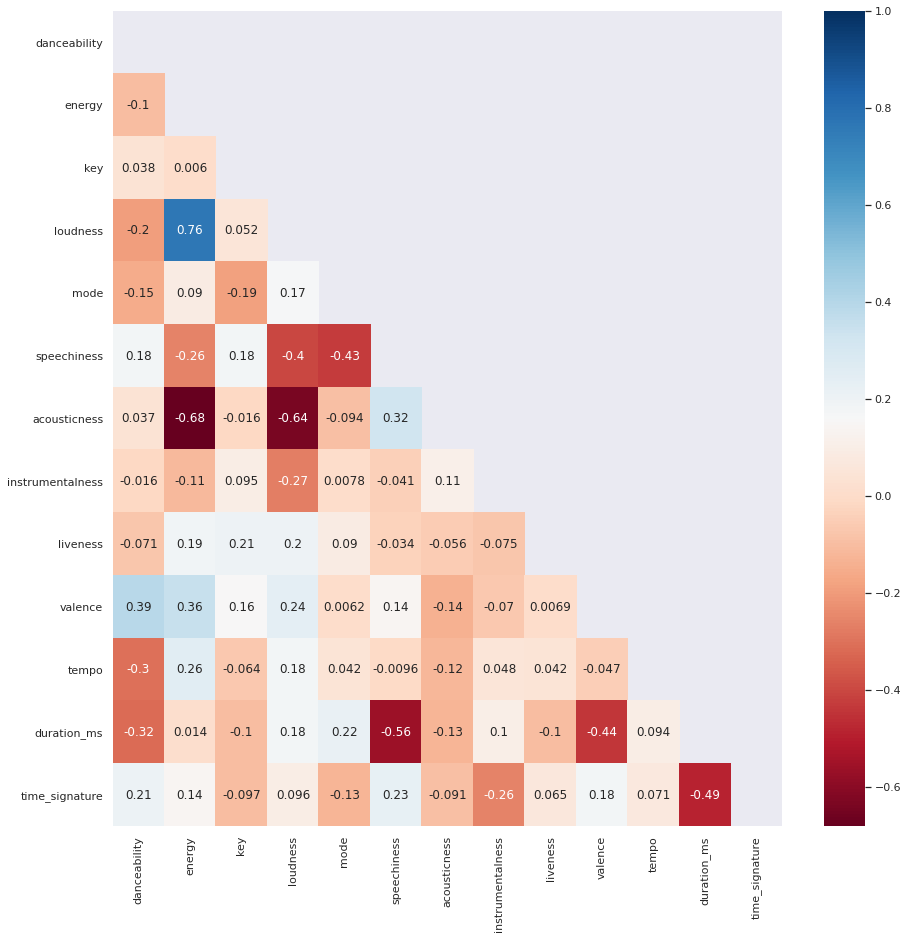

In [9]:
fig = plt.figure(figsize=(15,15))

corr =df.loc[:,'danceability':'time_signature'].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

sns.heatmap(corr,annot=True,mask=mask,cmap='RdBu')

Since, Loudness and Energy are the most correlated. Thus, remove loudness parameter altogether
Now analyse how the genres correlate to each other

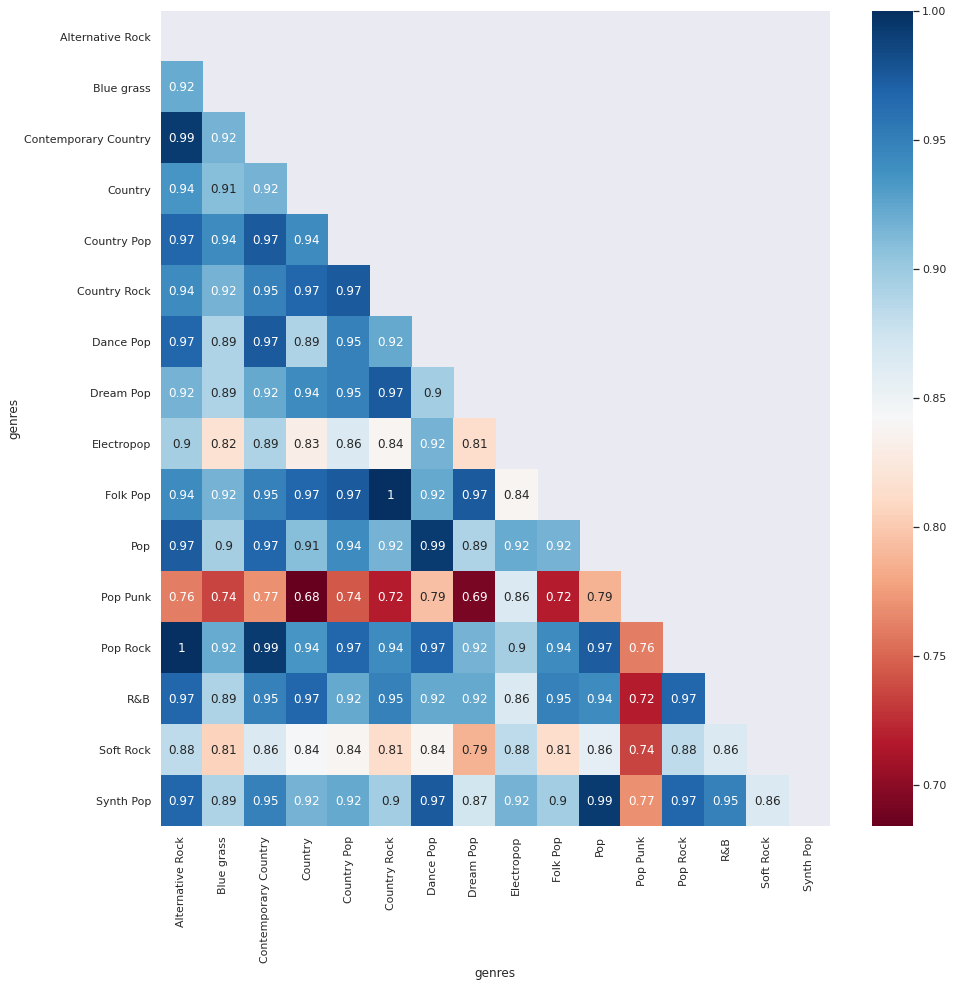

In [10]:
genre_rel= FeatureSet.groupby('genres').median().loc[:,'danceability':'time_signature']

corr=genre_rel.transpose().corr('kendall')
mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

fig = plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True,mask=mask,cmap='RdBu')

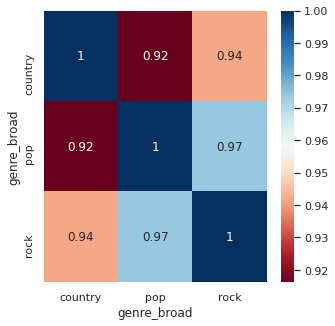

In [11]:
genre_rel= FeatureSet.groupby('genre_broad').median().loc[:,'danceability':'time_signature']

corr=genre_rel.transpose().corr('kendall')
#mask = np.triu(np.ones_like(corr, dtype=np.bool)) #For Lower Triangle, removes TriU

fig = plt.figure(figsize=(5,5))
sns.heatmap(corr,annot=True,cmap='RdBu')

### Distribution Plots
Now see the distribution of all the parametres of the spotify audio features.

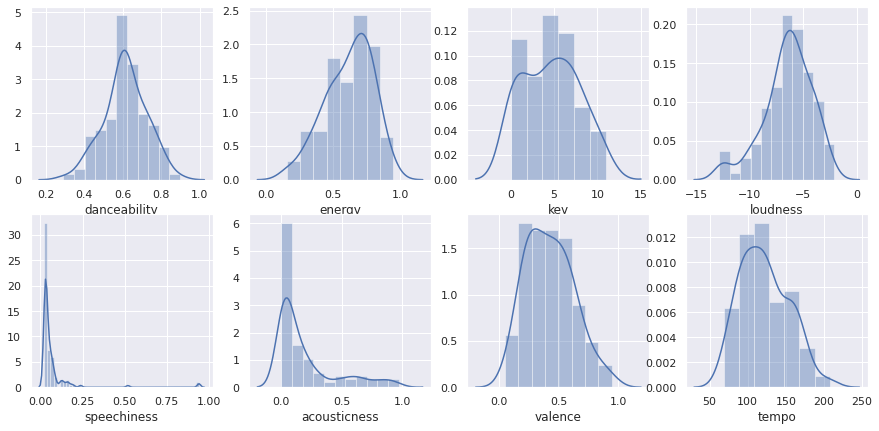

In [12]:
fig = plt.figure(figsize=(15,7))

fig.add_subplot(2,4,1)
sns.distplot(data.danceability)

fig.add_subplot(2,4,2)
sns.distplot(data.energy)

fig.add_subplot(2,4,3)
sns.distplot(data.key)

fig.add_subplot(2,4,4)
sns.distplot(data.loudness)

fig.add_subplot(2,4,5)
sns.distplot(data.speechiness)

fig.add_subplot(2,4,6)
sns.distplot(data.acousticness)

fig.add_subplot(2,4,7)
sns.distplot(data.valence)

fig.add_subplot(2,4,8)
sns.distplot(data.tempo)

## Modelling Classifiers
We will now model our classifiers. But first we must split our train and test sets

In [13]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

In [14]:
X = FeatureSet.loc[:,'danceability':'duration_ms'].drop(columns=['loudness','mode'])
y = FeatureSet.loc[:,'genre_broad']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

### Decision Tree Classifier

0.6666666666666666

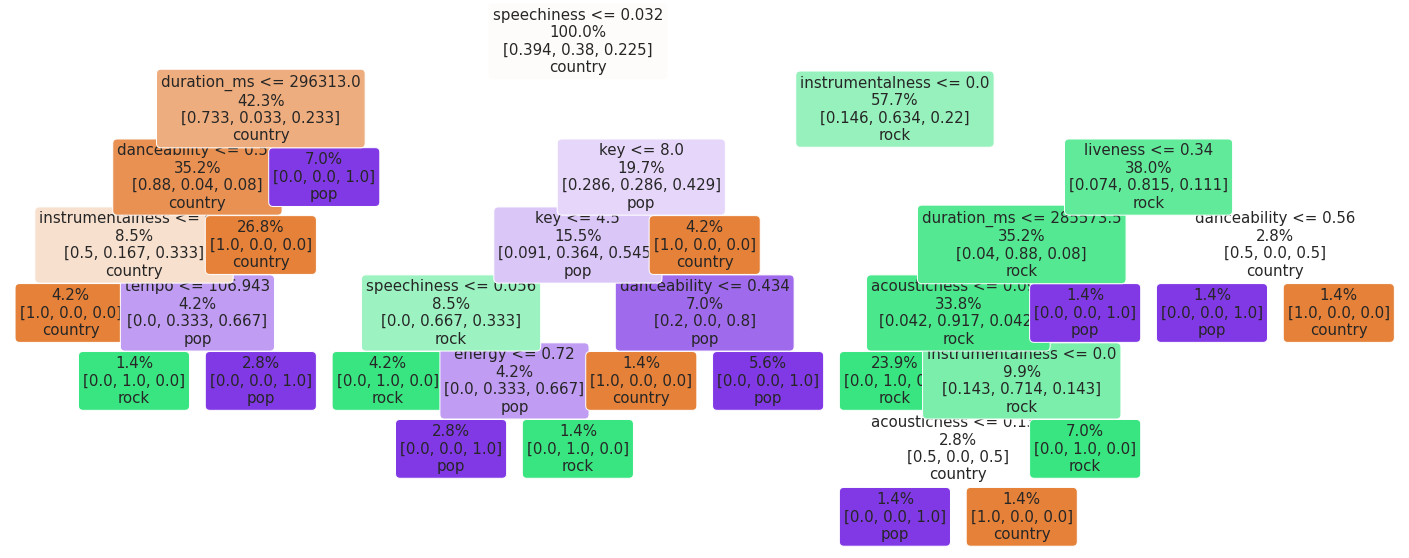

In [15]:
dt = DecisionTreeClassifier(min_samples_leaf=1)
dt.fit(X_train, y_train)

fig = plt.figure(figsize=(25,10))
#tree.plot_tree(dt);

a = plot_tree(dt, 
              feature_names=X.columns, 
              class_names=y.unique(), 
              label={"root"},
              proportion=True,
              filled=True, 
              impurity=False,
              rounded=True, 
              fontsize=15)

yhat=dt.predict(X_test)
dt.score(X_test,y_test)

### Random Forrest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7083333333333334

### Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(gnb.score(X_test, y_test))

mnb = MultinomialNB(alpha=1000)
print((mnb.fit(X_train, y_train)).score(X_test, y_test))

0.5416666666666666
0.4166666666666667


### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

0.4166666666666667